# Who has a voice in the media?

## 1. Pre-processing the dataset
To start with, we remove the rows of the dataset where either the author or the quotation is NaN. In addition, we remove the authors who probability is lower than 50%. As our whole analysis of "who has a voice in the media" is all about the speaker and what it has said, it makes no sense to take these rows into account.

Later, we also do a sanity controll and remove possible duplicate of rows with the same quote-ID as we obiously don't want to use exactly the same quote more than once in our analyzes. 

Finally, to reduce the dataset further we remove columns that we will not use for our analysis: _quoteID_, _speaker_, _probas_, _urls_, _phase_ and _numOccurrences_.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from datetime import datetime
from timeit import default_timer as timer
from collections import Counter
from qwikidata.linked_data_interface import get_entity_dict_from_api
from qwikidata.entity import WikidataItem
from pathlib import Path

In [ ]:
def clean_data(chunk, thresh=0.5):
    
    # Drop duplicate quoteIDs
    nr_rows = chunk.shape[0]
    chunk = chunk.drop_duplicates(subset=['quoteID'])
    print('- Dropped {} duplicate rows with same quoteID;'.format(nr_rows - chunk.shape[0]))
    
    # Drop quotes where either speaker or quotation is None
    nr_rows = chunk.shape[0]
    chunk.replace(to_replace=['None'], value=np.nan, inplace=True)
    chunk = chunk.dropna(axis=0, subset=['speaker', 'quotation'])
    print('- Dropped {} rows with NaN speaker or quotation;'.format(nr_rows - chunk.shape[0]))
    
    # Drop rows where speakers has probability less than 50%
    nr_rows = chunk.shape[0]
    prob_filter = pd.Series([(float(chunk.iloc[i].probas[0][1]) > thresh) for i in range(nr_rows)])
    prob_filter = pd.Series(prob_filter)
    chunk = chunk[prob_filter.values]
    print('- Dropped {} rows with speaker prob smaller than 50%;'.format(nr_rows - chunk.shape[0]))
    
    # Remove columns we don't care about
    chunk = chunk.drop(columns=['quoteID', 'speaker', 'probas', 'urls', 'phase', 'numOccurrences'])

    return chunk

start_of_all = timer()
read_from_file = 'data/quotes-2016.json.bz2'
write_to_file = 'data/clean-quotes-2016.bz2'
with pd.read_json(read_from_file, lines=True, compression='bz2', chunksize=1_000_000) as df_reader:
    print('Started to process chunks...')
    i = 0
    for chunk in df_reader:
        print('\nProcessing new chunk...')
        start = timer()
        processed_chunk = clean_data(chunk)
        processed_chunk.to_csv(write_to_file, compression='bz2', mode='a', index=False)
        end = timer()
        print('Done processing and saving chunk after {:.3f} seconds.'.format(end - start))
        
end_of_all = timer()
print('\nDONE processing all chunks and saving as csv after {:.3f} minutes.'.format((end_of_all - start_of_all) / 60))
print('THE END!')

#### Short discussion around pre-processing
Around one third of the original dataset has either a NaN quotation field, a NaN speaker, or a speaker with lower than 50% probability of having said that quote. Another one third of the original data is removed by the removal of the unwanted columns. Thus we are left with one third of the original dataset and still with full possibility of doing the wanted analysis

Elsemore, it seems like there are no duplicates of quote-IDs in the dataset.

## 2. Initial analyzes
Here, we do initial studies on the dataset. For instance we plot the following information about the speakers:
- age;
- ethnicity;
- gender;
- profession;
- top 10 speakers.

Also, we do analyzes on the content of the quotes.

In [2]:
df = pd.read_csv('data/clean-quotes-2020.bz2', compression='bz2')
df = df.sample(n=100_000, random_state=1)

author_attributes = pd.read_parquet('data/speaker_attributes.parquet')
author_attributes.set_index('id', inplace=True)

### Top 10 speakers

### Occupation
In this part of our initial analysis, we discover the distribution of occupations among the quoted speakers for the year of 2020. This can easily be extended to other years as well.

In [124]:
# Get the unique qids from the quotations df, we don't want to count the same speaker more than once:
unique_qids = df.qids.unique().tolist()

# Out of unique_qids, keep the qids of unambiguous authors whose qid exists in the parquet file:
wanted_qids = [eval(qid)[0] for qid in unique_qids if len(eval(qid)) == 1 and eval(qid)[0] in author_attributes.index]

# Get the rows of the authors having the wanted qids
authors = author_attributes.loc[wanted_qids]

# Get the authors occupations and count them
occupation_ids = [occ_id[0] for occ_id in authors.occupation.values if not occ_id is None]
occupation_count = Counter(occupation_ids)
occupation_count_sorted = dict(sorted(occupation_count.items(), key=lambda x: x[1], reverse=True)) 
top_50_occupations = dict(itertools.islice(occupation_count_sorted.items(), 50)) 

# Query wikidata for occupation labels
top_50_occupations_labels = [get_entity_dict_from_api(item)['labels']['en']['value'] for item in top_50_occupations.keys()]

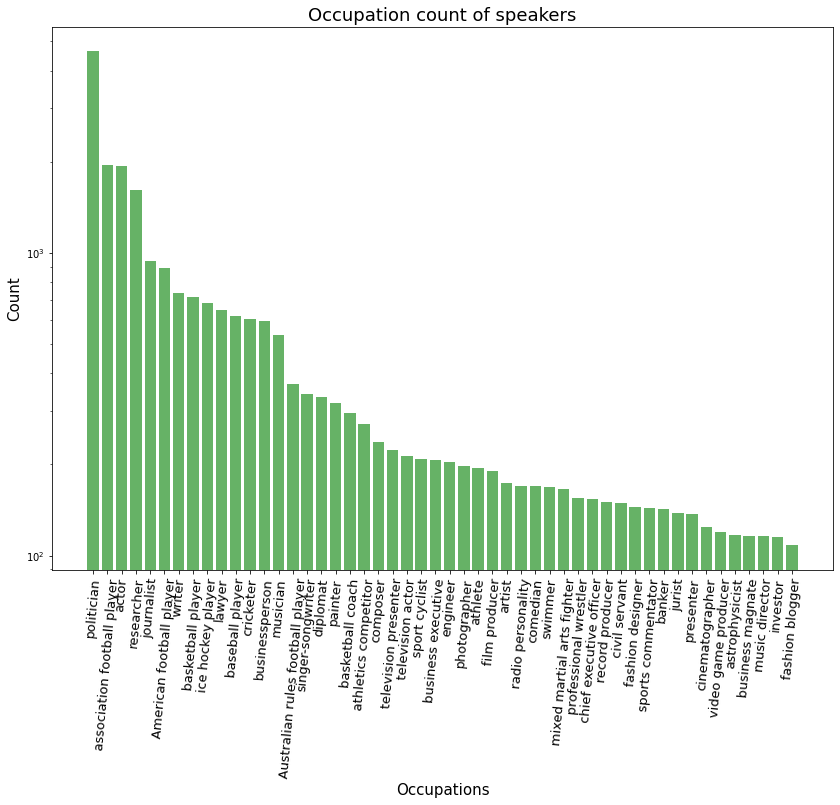

In [126]:
# Plot 
_ = plt.figure(figsize=(14, 10))
_ = plt.title('Occupation count of speakers', fontsize=18)
_ = plt.xlabel('Occupations', fontsize=15)
_ = plt.ylabel('Count', fontsize=15)
_ = plt.bar(top_50_occupations.keys(), top_50_occupations.values(), color='g', log=True, alpha=0.6)
_ = plt.xticks(range(len(top_50_occupations)), top_50_occupations_labels, rotation=85, fontsize=13)

We see that the greater number of quoted speakers are politicians, followed by football players, actors, researchers, journalists, etc.

### Age
In this part of our analysis, we discover the distribution of the age among the quoted speakers for the year of 2020.

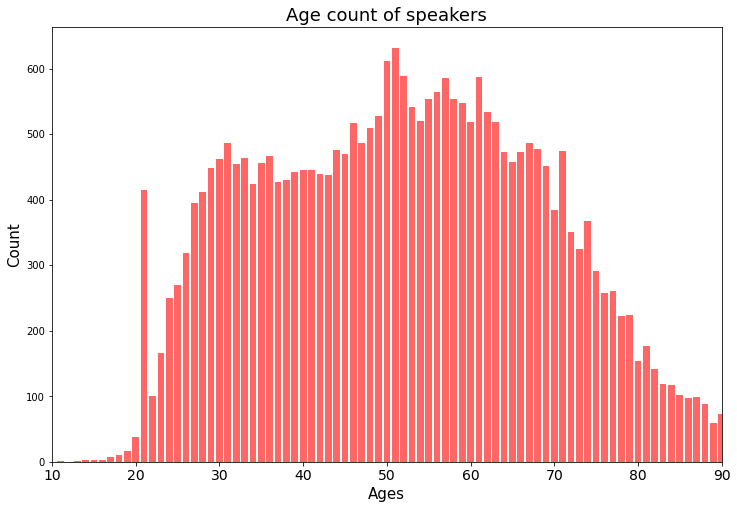

In [127]:
# OBS: We reuse the variable 'authors' found in the cell about Occupation.

# Get the ages of the 100_000 authors
current_year = datetime.now().year
ages = [current_year - int(date[0][1:5]) for date in authors.date_of_birth.values if not date is None]
ages_count = Counter(ages)

# Plot 
_ = plt.figure(figsize=(12, 8))
_ = plt.title('Age count of speakers', fontsize=18)
_ = plt.xlabel('Ages', fontsize=15)
_ = plt.ylabel('Count', fontsize=15)
_ = plt.xlim(10, 90)
_ = plt.bar(ages_count.keys(), ages_count.values(), color='r', log=False, alpha=0.6, width=0.8)
_ = plt.xticks(fontsize=14)

We see that the greater majority of the speakers are aged between 45 and 65 years. This is expected as politicians, which make the greater majority of this dataset as seen from the histogram aforementioned, use to be older adults. One interesting outlier is the peak at the age of 21 years; it might be interesting to discover who these quoted 21-year olds are.

### Ethnicity
In this part of our analysis, we discover the distribution of the ethnicity among the quoted speakers for the year of 2020.

In [119]:
# OBS: We reuse the variable 'authors' found in the cell about Occupation.
ethnicity_percentage = authors.ethnic_group.isna().sum() / authors.shape[0]
print('The percentage of authors with a set ethnicity value in the provided .parquet file is {:.2f}%.'.format((1-ethnicity_percentage)*100))

The percentage of authors with a set ethnicity value in the provided .parquet file is 5.19%.


In [156]:
ethnic_ids = [ethnic_id[0] for ethnic_id in authors.ethnic_group.values if not ethnic_id is None]
ethnic_count = Counter(ethnic_ids)

# Manual grouping of the top 20 ethnicity groups into: black, white and asian (ethnicities that American companies normally use)
ethnic_count_manual = {'black':  ethnic_count['Q49085'] + ethnic_count['Q190168'] + ethnic_count['Q244157'] + 
                                 ethnic_count['Q33938'] + ethnic_count['Q129962'],
                       
                       'white':  ethnic_count['Q7325'] + ethnic_count['Q678551'] + ethnic_count['Q2325516'] + 
                                 ethnic_count['Q170826'] + ethnic_count['Q974693'] + ethnic_count['Q1075293'] + 
                                 ethnic_count['Q42406'] + ethnic_count['Q842438'] + ethnic_count['Q49078'] + 
                                 ethnic_count['Q79797'] + ethnic_count['Q7994501'] + ethnic_count['Ashkenazi Jews'],
                       
                       'asians': ethnic_count['Q932244'] + ethnic_count['Q854323'] + ethnic_count['Q862086'],
                       
                       'indigeneous': 0
                      }

ethnic_count_sorted = dict(sorted(ethnic_count_manual.items(), key=lambda x: x[1], reverse=True)) 
# ethnic_count_sorted = dict(sorted(ethnic_count.items(), key=lambda x: x[1], reverse=True)) 
top_20_ethnicities = dict(itertools.islice(ethnic_count_sorted.items(), 20)) 

# Query wikidata for occupation labels
# top_20_ethnicities_labels = [get_entity_dict_from_api(item)['labels']['en']['value'] for item in top_20_ethnicities.keys()]

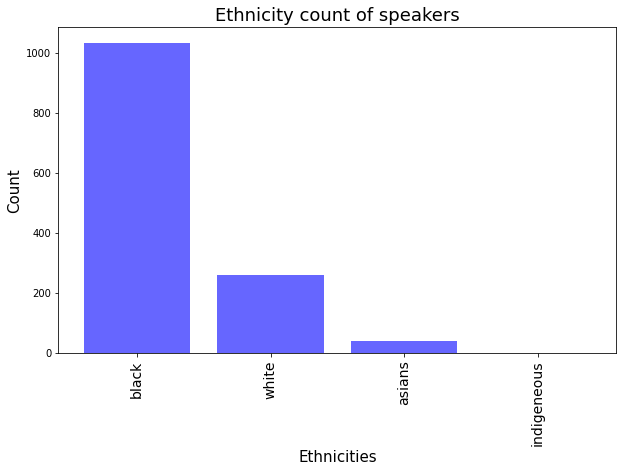

In [190]:
# Plot 
_ = plt.figure(figsize=(10, 6))
_ = plt.title('Ethnicity count of speakers', fontsize=18)
_ = plt.xlabel('Ethnicities', fontsize=15)
_ = plt.ylabel('Count', fontsize=15)
_ = plt.bar(top_20_ethnicities.keys(), top_20_ethnicities.values(), color='b', log=False, alpha=0.6)
_ = plt.xticks(range(len(top_20_ethnicities)), top_20_ethnicities, rotation=90, fontsize=14)

As can be seen from the calculations made on the random set of authors, the percentage of them who have a set _ethnicity value_ in the provided wikidata dump is only 5%. Furthermore, a manual grouping of the groups into the smaller groups white, black, asian and indigenous was made. The unexpected result that black people are quoted around 5 times more than white people was achieved as seen from the histogram above. A possible reason for this phenomenum is that black people's ethnicity are more often written than white in WikiData.

###